# Neural Networks, Part 2: Convolutional Layers

In the "Neural Networks, Part 1" notebook we introduced the most basic ways to build neural networks using fully-connected layers. This model is extremely general, which means that it will work with most types of data. However, there are some cases where we can take advantage of the structure of the data to improve our networks tremendously.

Right now the field which is booming the most from deep learning is __computer vision__, especially for autonomous driving. Computer vision is about giving machines the ability to see; naturally, the primary type of data that we deal with in computer vision is image data. So far we've treated an image as simply a list of pixels, with no regard to the overall structure of the image. When we do this, we several key aspects of images:

- Pixels tend to be similar (correlated) to their neighboring pixels
- Objects in an image can vary in location, size, rotation, etc.

What if we could modify our neural network so that it could take advantage of these properties of images? As it turns out, we can accomplish these things with __convolution__. Convolution is actually a very old technique that goes back to computer vision and then even further back to signal processing. In this notebook we're going to comandeer convolution for our own purposes as a __convolutional layer__, which can be plugged into a neural network to create a __convolutional neural network__, and we'll go through some additional details that come into play when using these layers. Finally, we'll take our original MLP image classifier, super-charge it with some convolutional layers, and see the difference in performance and accuracy.

## Machine Learning to Deep Learning: Where Are We?

There are a lot of buzzwords in our field, and __deep learning__ is by far the worst of them. Deep learning is considered a subset of machine learning, which is a subset of artificial intelligence. So everything we've done so far is definitely machine learning -- but at what point does machine learning also become deep learning? The answer is that this boundary isn't really well-defined. Deep learning generally refers to machine learning with "deep" models -- but by the same token, what makes a model "deep"? For this reason it's better to avoid the term "deep learning", because most people don't really know what it means. But as a guideline, if you're using neural networks with several layers -- and especially if you're using convolutional layers -- then you're probably doing "deep learning".

## Getting Started

You should have your own Anaconda virtual environment with all of the necessary Python modules installed. Additionally, this notebook is the first one which uses tensorflow, so __you need an NVIDIA GPU to use this notebook__ (unless you also installed the CPU version of tensorflow (but you probably didn't)). You can check by trying to import them:

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.color
import skimage.data
from tensorflow import keras

import sklearn.metrics

## Convolutions Demystified 

You may have already learned about convolution in another domain, such as math or electrical engineering. You may associate convolution with integrals, and great pain. Fortunately for you, we will not need integrals to use convolution with images. To do convolution on an image, we take a weight matrix and slide it (or "convolve" it) across the image, left to right, top to bottom, like this:

<img src="https://cufctl.github.io/creative-inquiry/assets/img/convolution.gif" alt="convolution" width=400/>

The weight matrix has many names, but we'll call it a __filter__ or __kernel__. At each location in the image, we compute a __weighted sum__ of the pixels in the given window, using the kernel elements as weights. At the end of it we get an "output image", where each "pixel" is the weighted sum centered on that pixel. So in the figure above, the blue square is the input image, the moving green square is the kernel, and the red square is the output of the convolution. Notice that we didn't slide the kernel over pixels where it would have been out of bounds, which means that the output image is smaller. We also usually use kernels that are square and have odd width and height, so that the kernel is centered on the output pixel.

We said that the output is an "image", but what does it represent, and can we even view it as an image? After all, the output is a weighted sum, and the weights can be anything, so we could get output values that are negative, or very large, or not even whole numbers! How about this: let's write some code that performs a convolution on an image and then tries to visualize the output.

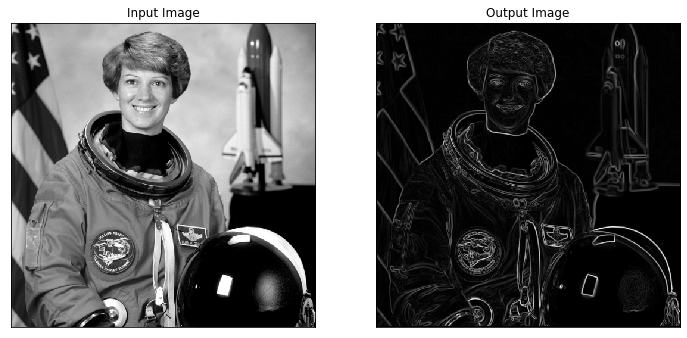

In [2]:
# load a sample image
image = skimage.data.astronaut()

# convert image to grayscale
gray = skimage.color.rgb2gray(image)

# define kernel
"""
W = np.array([
    [+1,  0, -1],
    [+2,  0, -2],
    [+1,  0, -1]
])
"""
"""
W = np.array([
     [+1, +2, +1],
     [ 0,  0,  0],
     [-1, -2, -1]
 ])
 
"""
Wx = np.array([
    [-1, 0, +1],
    [-2, 0, +2],
    [-1, 0, +1]
    
])

Wy = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [+1, +2, +1]
    
])


# compute convolved image
"""
convolved = np.zeros_like(gray)

for i in range(1, convolved.shape[0] - 1):
    for j in range(1, convolved.shape[1] - 1):
        convolved[i, j] = np.vdot(gray[i-1:i+2, j-1:j+2], Wx)

"""
# Sobel filter.
convolvedx = np.zeros_like(gray)
convolvedy = np.zeros_like(gray)
convolved  = np.zeros_like(gray)


for i in range(1, convolvedx.shape[0] - 1):
    for j in range(1, convolvedx.shape[1] - 1):
        convolvedx[i, j] = np.vdot(gray[i-1:i+2, j-1:j+2], Wx)
for i in range(1, convolvedy.shape[0] - 1):
    for j in range(1, convolvedy.shape[1] - 1):
        convolvedy[i, j] = np.vdot(gray[i-1:i+2, j-1:j+2], Wy)
for i in range(1, convolved.shape[0] - 1):
    for j in range(1, convolved.shape[1] - 1):
        convolved[i, j] = np.power(np.square(convolvedx[i, j])+ np.square(convolvedy[i, j]) , 0.5)       


# plot input image and output image
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(gray, cmap="gray")
plt.title("Input Image")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(122)
plt.imshow(convolved, cmap="gray")
plt.title("Output Image")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.show()

# TODO: experiment with other filters (Sobel, Canny, Prewitt, Laplacian, etc.)

In [47]:
np.power(4, 0.5)

2.0

Thanks to the `imshow` function in matplotlib, we can pass the output image and its values are automatically scaled to form a proper grayscale image. The kernel we used is actually a simple edge detection filter -- it causes the output to be high around edges and low everywhere else. We can also call this output image a __feature map__ or __activation map__, because it is essentially a map of the important information that was seen by the filter.

## Elements of CNNs

Now that we have a working definition of convolution we can focus on how to incorporate them into our neural network. In particular, there are three new elements that we'll need in order to make convolution work in a neural network: the __convolutional layer__, the __ReLU activation__, and the __pooling layer__.

### Convolutional Layer

This figure shows what a convolutional layer does:

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" alt="depth-column" width=300/>

The red square is the input image. We say that an image has a __width__, __height__, and __depth__. The height and width are intuitive -- in this figure they are 32x32 -- but you may not be used to thinking of an image as having "depth". So far we've only worked with grayscale images, where each pixel has a single "gray" value. In a color image, however, each pixel has three components: red, green, and blue. This type of color image is called an __RGB image__, and the components are called __channels__. Now we can stack these channels so that the image is actually 32x32x3. This means that our kernel -- the small dark red square inside the image -- will also have a depth of 3, in addition to whatever it's width and height are.

The blue cube, which we call the __output volume__, represents the neurons in the output layer. The kernel will be the weight matrix of the convolutional layer, that is, it will represent the connections from the input layer to each neuron in the output layer. There are two key aspects to understand here. First, each neuron in the ouput volume is connected to only a small region of input pixels, rather than all of the input pixels as in a fully-connected layer. Second, every neuron is sharing the same weight matrix! Can you see how this structure is addressing exactly the problems we mentioned before? Now we are focusing on neighboring regions of pixels instead of whole images, and we're accounting for the fact that certain patterns could occur anywhere in the image.

However there's one more thing that we kind of ignored: why is the output a _cube_?! Shouldn't it just be a square? The answer is yes, it would be a square, _if we were only using one kernel_. When we use convolutional layers, we almost always have several kernels in each layer. Each kernel slides across the input image in exactly the same way, but because the kernels will be initialized differently, the idea is that they will each learn a different pattern in the image. One kernel might learn a vertical edge, another kernel a horizontal edge, a third kernel a diagonal edge, and so on. See the blue circles forming a column in the output volume? We call that a __depth column__ -- it represents a group of neurons that are looking at the same region in an image, but through different kernels.

So how big is the output volume? The depth is equal to the number of filters -- every filter produces an activation map. The weight and height depend on a number of factors, which we can summarize in the following equations:

$$W_o = (W_i - F + 2 P) / S + 1$$
$$H_o = (H_i - F + 2 P) / S + 1$$

Where $(W_i, H_i)$ is the input size, $F$ is the width/height of the filter (which we assume is square), $P$ is the amount of __zero padding__, and $S$ is the __stride__. Zero padding refers to adding a border of zeros around the input image, and the stride refers to how far the kernel steps when it slides across the input. We almost always use $F = 2 P + 1$ and $S = 1$, which makes these equations simpler (just a little bit):

$$W_o = W_i$$
$$H_o = W_i$$

In other words, we leave the stride set to 1 (just like the convolution examples from before) and we fix the filter size and zero padding so that the output volume always has the same width and height as the input -- if we use 3x3 kernels then we'll add one layer of zeros, if we use 5x5 kernels then we'll add two layers of zeros, and so on. It's just simpler that way.

### ReLU Activation

<img src="http://cs231n.github.io/assets/nn1/relu.jpeg" alt="relu" width=300/>

So far we've mainly use the sigmoid activation, but there's a new activation function in town that's both simpler and better. It's called the __rectified linear unit (ReLU)__:

$$ReLU(x) = max(0, x)$$

How is it better? Well, Alex Krizhevsky (et. al.) found that their network trained much more quickly when they used ReLU instead of sigmoid. It wasn't that the computations were faster, but that the network didn't need to be trained for as many iterations -- it converged more quickly. We'll use this activation after each convolutional layer, and when we add a few fully-connected layers to the end of our network, we'll use ReLU there too.

### Pooling Layer

<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" alt="max-pooling" width=400/>

A pooling layer is essentially a "downsampling" layer -- it breaks the input image into chunks and takes only one value from each chunk. This layer doesn't have any neurons, it just has two settings: (1) the size of the chunks and (2) how to select a value from each chunk. The figure above shows a 2x2 __max-pooling layer__, because each chunk is 2x2 and the maximum value is taken from each chunk. There are other types of pooling layers, like min-pooling and mean-pooling, but max-pooling tends to give the best results, and with good reason. Remember that the output of a convolution is a map that represents what the convolution kernel is "paying attention" to, so by taking only the highest values in each region we are taking the most important features that were computed by the convolutional layer.

We typically use convolutional layers and pooling layers in pairs: the convolutional layer produces an activation map with the same size as the input, and then the pooling layer downsamples the activation map by halving the width and height. At each step, the output volume becomes thinner and deeper, until eventually we can flatten it into a vector and use fully-connected layers at the end of the network.

## Implementing CNNs in Keras 

Finally! It's time to create our own CNN in Keras. As before we're going to create an image classifier, but this time we're going to incorporate convolutional layers to improve performance and accuracy. We're also going to graduate once again from MNIST to another image dataset, the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The CIFAR-10 dataset has 60,000 color images, with each image having a size of 32x32x3. As usual, we'll load the dataset and visualize a few samples:

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print("X_train: %s" % str(X_train.shape))
print("y_train: %s" % str(y_train.shape))
print("X_test: %s" % str(X_test.shape))
print("y_test: %s" % str(y_test.shape))

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


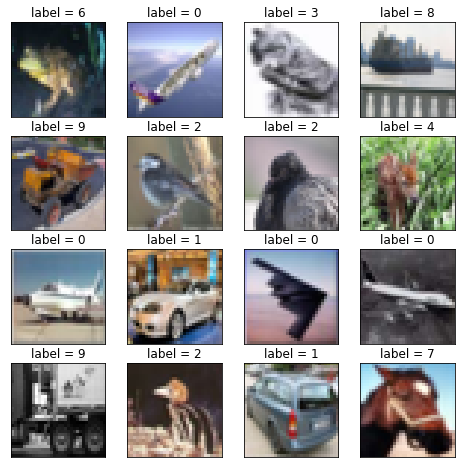

In [4]:
# select several samples from CIFAR-10 at random
rows = 4
cols = 4
indices = np.random.choice(np.arange(len(X_train)), rows * cols)

# plot the images in a grid
plt.figure(figsize=(2 * cols, 2 * rows))

for i in range(rows * cols):
    index = indices[i]
    
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(X_train[index])
    plt.title("label = %d" % y_train[index])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

These images aren't much bigger than the ones in MNIST, but they're color images, and they're taken from a variety of real-world settings. In other words, it's probably going to be more difficult to classify these images than to classify handwritten digits.

The code to create, train, and evaluate a CNN is largely similar to what we've done before, but this time we'll need a few more types of layers.

In [5]:
# create a basic convolutional neural network
cnn = keras.models.Sequential() 
cnn.add(keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32,32,3)))
cnn.add(keras.layers.MaxPooling2D(2, 2))
cnn.add(keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(keras.layers.MaxPooling2D(2, 2))
cnn.add(keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(1024, activation="relu"))
cnn.add(keras.layers.Dense(10, activation="softmax"))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4195328   
__________

So we've created a tiny CNN. We've introduced three new types of layers, so we'll go through each of them. The `Conv2D` layer is defined primarily by the number of filters and the size of each filter (in contrast to the `Dense` layer, which is defined by the number of output units). We'll adjust the zero-padding to ensure that the output size always matches the input size, which we can specify by simply saying `"same"`. We'll use ReLU activation for every convolutional layer _and_ every fully-connected layer. The `MaxPooling2D` layer does exactly what it says; we only specify the pool size, which is 2x2. The `Flatten` layer simply flattens the output volume into a vector so that it can be passed to a fully-connected layer.

As before, we only specify the input shape for the first layer as the shape of the input data, and Keras automagically deduces the shapes of the remaining layers for you. And this time, we don't have to flatten the input data because we're using it as-is. Neat!

Finally, notice that the end of our CNN contains fully-connected layers just like before. As a result the output of our CNN -- and consequently the training and testing procedure for it -- is _exactly the same_ as our MLP from the previous notebook. So let's do it!

In [6]:
# normalize the data
X_norm_train = X_train.astype("float32") / 255.
X_norm_test = X_test.astype("float32") / 255.

# compute one-hot labels
y_cate_train = keras.utils.to_categorical(y_train, num_classes=10)
y_cate_test = keras.utils.to_categorical(y_test, num_classes=10)

# compile the model
cnn.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# train the model
history = cnn.fit(x=X_norm_train, y=y_cate_train, batch_size=500, epochs=50, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 8s 167us/step - loss: 2.2735 - acc: 0.1460 - val_loss: 2.2387 - val_acc: 0.2144
Epoch 2/50
45000/45000 [==============================] - 2s 45us/step - loss: 2.1769 - acc: 0.2349 - val_loss: 2.1005 - val_acc: 0.2682
Epoch 3/50
45000/45000 [==============================] - 2s 45us/step - loss: 2.0648 - acc: 0.2613 - val_loss: 2.0173 - val_acc: 0.2824
Epoch 4/50
45000/45000 [==============================] - 2s 45us/step - loss: 2.0014 - acc: 0.2876 - val_loss: 2.0586 - val_acc: 0.2714
Epoch 5/50
45000/45000 [==============================] - 2s 45us/step - loss: 1.9546 - acc: 0.3110 - val_loss: 1.9158 - val_acc: 0.3292
Epoch 6/50
45000/45000 [==============================] - 2s 45us/step - loss: 1.9028 - acc: 0.3335 - val_loss: 1.8810 - val_acc: 0.3388
Epoch 7/50
45000/45000 [==============================] - 2s 45us/step - loss: 1.8587 - acc: 0.3492 - val_loss: 1.8548 - val_acc

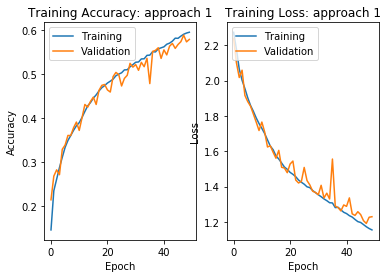

In [10]:
# TODO: use the history to plot training accuracy and training loss (refer to previous notebook)
def plot_acc_and_score(which_history,which_mlp,which_approach):
# plot the training accuracy
    plt.subplot(1,2, 1)
    plt.plot(which_history.history["acc"])
    plt.plot(which_history.history["val_acc"])
    plt.title("Training Accuracy: "+ which_approach)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper left")

 

    
    # plot the training loss
    plt.subplot(1,2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Training Loss: "+ which_approach)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"], loc="upper left")
    
    plt.show()


plot_acc_and_score(history,cnn,"approach 1")

In [11]:
# evaluate the model
score = cnn.evaluate(x=X_norm_test, y=y_cate_test)

print("test loss:     %g" % score[0])
print("test accuracy: %g" % score[1])

10000/10000 [==============================] - 0s 46us/step
test loss:     1.22376
test accuracy: 0.5739


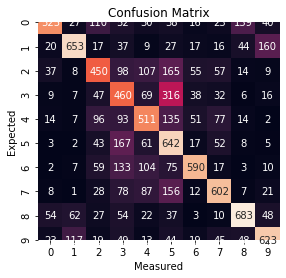

In [12]:
# TODO: use cnn.predict() plot a confusion matrix (refer to previous notebooks)# get the raw predictions of the network on the test set
y_cate_pred = cnn.predict(X_norm_test)

# convert the one-hot encoded output to class indexes
y_pred = np.argmax(y_cate_pred, axis=1)
classes = [str(i) for i in range(10)]
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

# plot a heatmap of the confusion matrix
sns.heatmap(cnf_matrix, annot=True, fmt="d", cbar=False, square=True, xticklabels=classes, yticklabels=classes)
plt.ylabel("Expected")
plt.xlabel("Measured")
plt.title("Confusion Matrix")
plt.show()


Chances are that you're going to have to train the network for many more epochs before it achieves a high accuracy, and that's fine. Models that are more complex generally take longer to train. We've only shown you the process so that you know what it looks like; from here it's up to you to train and monitor your network until it performs well.

## Convolutional Autoencoder

As a side note, we can revisit our strange friend the autoencoder and apply the same techniques from this notebook to create a __convolutional autoencoder__ -- an autoencoder with convolutional layers. The only new thing here is that we use "up-sampling" layers in the decoder to mirror the max-pooling layers in the encoder. As in the previous notebook, we'll go ahead and give you the code to train the autoencoder and compare test images to their reconstructed counterparts:

In [22]:
# create a convolutional autoencoder
ae = keras.models.Sequential()

# encoder
ae.add(keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3))) 
ae.add(keras.layers.MaxPooling2D((2, 2)))
ae.add(keras.layers.Conv2D(8, (3, 3), activation="relu", padding="same")) 
ae.add(keras.layers.MaxPooling2D((2, 2)))

# decoder
ae.add(keras.layers.Conv2D(8, (3, 3), activation="relu", padding="same")) 
ae.add(keras.layers.UpSampling2D((2, 2)))
ae.add(keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same")) 
ae.add(keras.layers.UpSampling2D((2, 2)))
ae.add(keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same"))

ae.compile(optimizer="adadelta", loss="binary_crossentropy")

# print model summary
ae.summary()

# normalize the data
X_norm_train = X_train.astype("float32") / 255.
X_norm_test = X_test.astype("float32") / 255.

# train the model
history = ae.fit(x=X_norm_train, y=X_norm_train, batch_size=500, epochs=50, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 16)        1168      
__________

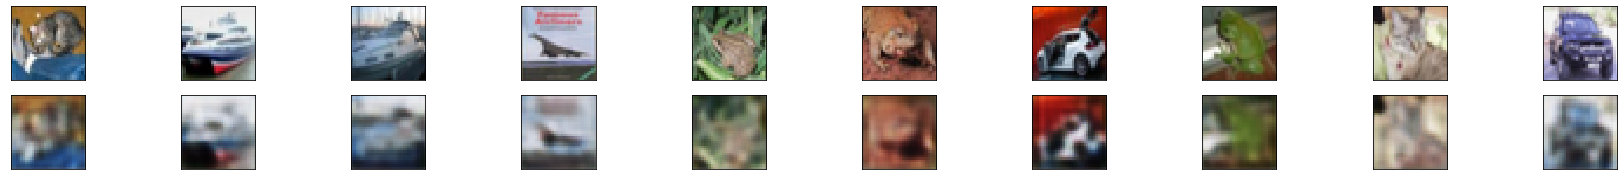

In [23]:
# reconstruct test images with the trained autoencoder
X_reconstructed = ae.predict(X_norm_test)

# sample some test images for visualization
num_images = 10
indices = np.random.choice(np.arange(len(X_norm_test)), num_images)

# plot each sample image and its reconstructed counterpart
plt.figure(figsize=(3 * num_images, 3))

for i in range(num_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(X_norm_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(X_reconstructed[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Assignment: It's Convolutions All The Way Down!!!

There's a lot of information in this notebook. It's beginning to be a pattern, isn't it? Once again, if you'd like to learn more about convolutional neural networks and how to use them, we highly recommend that you check out [CS231n](http://cs231n.github.io/) and the [Keras documentation](https://keras.io/).

In the meantime, we'll expand on the assignment from the previous notebook by applying it to CNNs. In addition to the network size, we now have a slew of new hyperparameters related to convolutional layers. On top of that, we'll need to pay more attention to how we train the CNN because it's a more complex model. To that end, create and train a variety of networks by experimenting with the following hyperparameters:

- filter size (3x3, 5x5, 7x7, etc.)
- number of filters (8, 16, 32, 64, etc.)
- batch size
- number of epochs

As before, use the following metrics to evaluate each model:

- training loss
- training accuracy
- test loss
- test accuracy

To make things easier on yourself, try to encapsulate the entire training / evaluation procedure into a function that you can call repeatedly. We'll get you started with a function called `evaluate_cnn`, which takes a "layer config" as a short-hand for creating a network.

In [24]:
def evaluate_cnn(layers, X_norm_train, y_cate_train, X_norm_test, y_cate_test):
    """
    Create, train, and evaluate a convolutional neural network.
    
    The first layer is assumed to be a convolutional layer, and the
    last layer is assumed to be a fully-connected layer. ReLU activation
    is used for all convolutional and fully-connected layers, except for
    the final layer, in which softmax is used.
    
    We define the following mapping for creating different layers: 
      ("c", 32, 3) -> create a Conv2D with 32 output channels and kernel size of 3x3
      ("m", 2) -> create a MaxPooling2D with pool size of 2x2 
      ("d", 1024) -> create a fully-connected layer with 1024 units 
      ("f", None) -> flatten the output volume from the previous layer

    Args:
    layers: A list of tuples specifiying the type and size of each layer.
    X_norm_train
    y_cate_train
    X_norm_test
    y_cate_test
    
    Returns: evaluation metrics
    """
    model = keras.models.Sequential()

    for i, layer in enumerate(layers):
        if layer[0] == "c":
            if i == 0:
                model.add(keras.layers.Conv2D(layer[1], (layer[2],layer[2]), padding="same", activation="relu", input_shape=X_norm_train.shape[1:]))
            else:
                model.add(keras.layers.Conv2D(layer[1], (layer[2],layer[2]), padding="same", activation="relu"))
        elif layer[0] == "m":
            model.add(keras.layers.MaxPooling2D((layer[1], layer[1])))
        elif layer[0] == "f":
            model.add(keras.layers.Flatten())
        elif layer[0] == "d":
            if i == len(layers) - 1:
                model.add(keras.layers.Dense(layer[1], activation="softmax"))
            else:
                model.add(keras.layers.Dense(layer[1], activation="relu"))
    
    # TODO: complete this function by adding training, evaluation, and visualization



# an example config for the network we used previously
layers = [
    ("c", 32, 3),
    ("m", 2),
    ("c", 64, 3),
    ("m", 2),
    ("c", 64, 3),
    ("f", None),
    ("d", 1024),
    ("d", 10)
]

evaluate_cnn(layers, X_norm_train, y_cate_train, X_norm_test, y_cate_test)